# Lighting Test

In [ ]:
import sys, os
__basedir__ = os.path.dirname(os.path.realpath('.'))
print(__basedir__)
if __basedir__ not in sys.path:
     sys.path.insert(0, __basedir__)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [1]:
import tensorflow as tf
import numpy as np
import imageio
import json
import random
import time

from run_nerf_helpers import *
import nerf_renderer as nr
from misc_helpers import *
from load_llff import load_llff_data

In [2]:
USE_LIGHTING = True
USE_PHONG_FULL = True
USE_MU_SMOOTHING = True
SAMPLING_MULTIPLIER = 2.0

In [3]:
def pose_to_rays(H, W, focal, c2w, near=0., far=1., ndc=False):
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    viewdirs = rays_d
    viewdirs = viewdirs / tf.linalg.norm(viewdirs, axis=-1, keepdims=True)
    viewdirs = tf.cast(tf.reshape(viewdirs, [-1, 3]), dtype=tf.float32)

    sh = rays_d.shape  # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, focal, tf.cast(1., tf.float32), rays_o, rays_d)

    # Create ray batch
    rays_o = tf.cast(tf.reshape(rays_o, [-1, 3]), dtype=tf.float32)
    rays_d = tf.cast(tf.reshape(rays_d, [-1, 3]), dtype=tf.float32)
    near, far = near * \
        tf.ones_like(rays_d[..., :1]), far * tf.ones_like(rays_d[..., :1])

    # (ray origin, ray direction, min dist, max dist) for each ray
    rays = tf.concat([rays_o, rays_d, near, far], axis=-1)
    rays = tf.concat([rays, viewdirs], axis=-1)
    return rays

In [4]:
def nerf_raw2weights(raw, z_vals, rays_d):  
    def raw2alpha(raw, dists, act_fn=tf.nn.relu): return 1.0 - \
        tf.exp(-act_fn(raw) * dists)

    dists = z_vals[..., 1:] - z_vals[..., :-1]
    dists = tf.concat(
        [dists, tf.broadcast_to([1e10], dists[..., :1].shape)],
        axis=-1)  # [N_rays, N_samples]

    dists = dists * tf.linalg.norm(rays_d[..., None, :], axis=-1)

    rgb = tf.math.sigmoid(raw[..., :3])  # [N_rays, N_samples, 3]

    noise = 0.
    # if raw_noise_std > 0.:
    #     noise = tf.random.normal(raw[..., 3].shape) * raw_noise_std

    alpha = raw2alpha(raw[..., 3] + noise, dists)  # [N_rays, N_samples]

    mu_expected = tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True)
    weights = alpha * mu_expected 

    return weights

In [5]:
def nerf_raw2outputs2(raw, z_vals, rays_d):   
    def raw2alpha(raw, dists, act_fn=tf.nn.relu): return 1.0 - \
        tf.exp(-act_fn(raw) * dists)

    dists = z_vals[..., 1:] - z_vals[..., :-1]

    dists = tf.concat(
        [dists, tf.broadcast_to([1e10], dists[..., :1].shape)],
        axis=-1)  # [N_rays, N_samples]

    dists = dists * tf.linalg.norm(rays_d[..., None, :], axis=-1)
    rgb = tf.math.sigmoid(raw[..., :3])  # [N_rays, N_samples, 3]
    noise = 0.
    # if raw_noise_std > 0.:
    #     noise = tf.random.normal(raw[..., 3].shape) * raw_noise_std

    alpha = raw2alpha(raw[..., 3] + noise, dists)  # [N_rays, N_samples]
    mu_expected = tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True) 
    
    return rgb, alpha, mu_expected

In [6]:
def get_mu(pts, viewdirs, model_mu, embed_fn, embeddirs_fn):

    pts_flat = tf.reshape(pts, [-1, pts.shape[-1]])
    embedded = embed_fn(pts_flat)
    
    input_dirs_flat = tf.reshape(viewdirs, [-1, viewdirs.shape[-1]])
    embedded_dirs = embeddirs_fn(input_dirs_flat)
    embedded = tf.concat([embedded, embedded_dirs], -1)

    outputs_flat = model_mu(embedded)
    mu_out = tf.reshape(outputs_flat, list(
        pts.shape[:-1]) + [outputs_flat.shape[-1]])
    return mu_out

In [7]:
def get_volume_density(nerf_model_data, pts, viewdirs, z_vals, rays_d):
    model, embed_fn, embeddir_fn = nerf_model_data
    raw = nr.run_network(pts, viewdirs, model, embed_fn, embeddir_fn)
    _, alpha, _ = nerf_raw2outputs2(raw, z_vals, rays_d)
    return alpha

In [8]:
def get_illumination(light, pts, models, helper_data):   

    light_loc = tf.cast(light['loc'], tf.float32) 
    intensity = tf.cast(light['intensity'], tf.float32) 
    light_color = tf.cast(light['color'], tf.float32) 

    viewdirs = pts - tf.broadcast_to(light_loc, shape = pts.shape)  
    dists = tf.linalg.norm(viewdirs, axis=-1, keepdims=True)
    viewdirs = viewdirs / dists
    dists = tf.reshape(dists, dists.shape[:-1])
    inv_dists_sq = 1. / (dists * dists)

    model_mu, mu_embed_fn, mu_embeddirs_fn = models['model_mu']
    mu = get_mu(pts, viewdirs, model_mu, mu_embed_fn, mu_embeddirs_fn)
    mu = tf.reshape(mu, shape = pts.shape[:-1])
    mu = tf.math.tanh(tf.nn.relu(mu))

    if USE_MU_SMOOTHING:
        mu_ = tf.concat([mu[:, :1], mu[:, :-1]], 1)
        mu = (mu + mu_) * 0.5

    # approximate angle between incident light and surface normal
    ang = 1.

    if USE_PHONG_FULL:
        dr, pts_alpha, cam_viewdirs, z_vals, rays_d = helper_data
        ext_pts = pts - (viewdirs * dr)
        ext_pts_alpha = get_volume_density(models['model_fine'], ext_pts, cam_viewdirs, z_vals, rays_d)
        ang = (pts_alpha - ext_pts_alpha) / (pts_alpha + 1e-10)
        ang = tf.clip_by_value(ang, 0., 1.)
        # print(ang.shape)
        if USE_MU_SMOOTHING:
            ang_ = tf.concat([ang[:, :1], ang[:, :-1]], 1)
            ang = (ang + ang_) * 0.5

    ret = mu * intensity * inv_dists_sq * ang
    ret = ret[..., None]
    ret = tf.broadcast_to(ret, shape = list(ret.shape[:-1]) + [3]) 
    ret *= light_color
    
    return  ret

In [9]:
def process_ray_batch(ray_batch,
                      models,
                      light_data,
                      N_samples,
                      retraw=False,
                      lindisp=False,
                      perturb=0.,
                      N_importance=0,
                      white_bkgd=False,
                      raw_noise_std=0.,
                      verbose=False):

    assert('model' in models and 'model_fine' in models and 'model_mu' in models and N_importance > 0)

    N_rays = ray_batch.shape[0]

    # Extract ray origin, direction.
    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]  # [N_rays, 3] each

    # Extract unit-normalized viewing direction.
    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] > 8 else None

    # Extract lower, upper bound for ray distance.
    bounds = tf.reshape(ray_batch[..., 6:8], [-1, 1, 2])
    near, far = bounds[..., 0], bounds[..., 1]  # [-1,1]
    
    # Decide where to sample along each ray. Under the logic, all rays will be sampled at
    # the same times.
    t_vals = tf.linspace(0., 1., N_samples)
    if not lindisp:
        # Space integration times linearly between 'near' and 'far'. Same
        # integration points will be used for all rays.
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        # Sample linearly in inverse depth (disparity).
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))
    z_vals = tf.broadcast_to(z_vals, [N_rays, N_samples])

    # Perturb sampling time along each ray.
    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = tf.concat([mids, z_vals[..., -1:]], -1)
        lower = tf.concat([z_vals[..., :1], mids], -1)
        # stratified samples in those intervals
        t_rand = tf.random.uniform(z_vals.shape)
        z_vals = lower + (upper - lower) * t_rand

    # Points in space to evaluate model at.
    pts = rays_o[..., None, :] + rays_d[..., None, :] * \
        z_vals[..., :, None]  # [N_rays, N_samples, 3]
    pts_0 = pts

    # Evaluate model at each point.
    model_coarse, c_embed_fn, c_embeddir_fn = models['model']
    raw = nr.run_network(pts, viewdirs, model_coarse, c_embed_fn, c_embeddir_fn)  # [N_rays, N_samples, 4]
    weights = nerf_raw2weights(raw, z_vals, rays_d)    
    # print(weights.shape)

    # Obtain additional integration times to evaluate based on the weights
    # assigned to colors in the coarse model.
    z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
    z_samples = sample_pdf(
        z_vals_mid, weights[..., 1:-1], N_importance, det=(perturb == 0.))
    z_samples = tf.stop_gradient(z_samples)

    # Obtain all points to evaluate color, density at.
    z_vals = tf.sort(tf.concat([z_vals, z_samples], -1), -1)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * \
        z_vals[..., :, None]  # [N_rays, N_samples + N_importance, 3]

    # Make predictions with network_fine.
    model_fine, f_embed_fn, f_embeddir_fn = models['model_fine']
    raw = nr.run_network(pts, viewdirs, model_fine, f_embed_fn, f_embeddir_fn)
    rgb, alpha, mu_nerf = nerf_raw2outputs2(raw, z_vals, rays_d)
    
    # print(rgb.shape, alpha.shape, mu_expected.shape)

    if USE_LIGHTING:
        # Calculate illuminations from light sources
        _n, _f = np.mean(near), np.mean(far)
        dr = abs(_f - _n)/((N_samples + N_importance) * SAMPLING_MULTIPLIER)
        helper_data = dr, alpha, viewdirs, z_vals, rays_d

        ambient = tf.cast(light_data['ambient'], tf.float32)  
        total_illuminations = tf.broadcast_to(ambient, shape = list(pts.shape[:-1]) + [3])

        for light in light_data['lights']:        
            total_illuminations += get_illumination(light, pts, models, helper_data)
        
        total_illuminations = tf.clip_by_value(total_illuminations, 0., 1.)
        weights = alpha * mu_nerf 
        weights = weights[..., None] * total_illuminations    
    else:
        weights = alpha * mu_nerf 
        weights = weights[..., None]

    rgb = tf.reduce_sum(weights * rgb, axis=-2)
    light_map = tf.reduce_sum(weights, axis=-2)
    
    return rgb, light_map


In [10]:
def get_rgb_test(render_data, models, light_data, chunk_size = 1024*32, **kwargs):    
    H, W, focal, c2w, near, far = render_data
    ray_data = pose_to_rays(H, W, focal, c2w, near, far, ndc = False)
    
    rgb_composite = []
    light_maps = []
    for i in range(0, ray_data.shape[0], chunk_size):        
        ray_batch = ray_data[i : i+chunk_size]
        rgb, lm = process_ray_batch(ray_batch, models, light_data, **kwargs)
        rgb_composite.append(rgb)
        light_maps.append(lm)
    
    final_rgb = tf.concat(rgb_composite, axis = 0)
    final_rgb = tf.reshape(final_rgb, (H, W, 3))
    final_rgb = tf.clip_by_value(final_rgb, 0., 1.)

    final_light_map = tf.concat(light_maps, axis = 0)
    final_light_map = tf.reshape(final_light_map, (H, W, 3))
    final_light_map = tf.clip_by_value(final_light_map, 0., 1.)

    return final_rgb, final_light_map

In [11]:
def load_models(args):
    models = {}

    embed_fn, input_ch = get_embedder(args.multires, args.i_embed)
    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(
            args.multires_views, args.i_embed)
    output_ch = 4
    skips = [4]

    model = init_nerf_model(
        D=args.netdepth, W=args.netwidth,
        input_ch=input_ch, output_ch=output_ch, skips=skips,
        input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)
    models = {'model': [model, embed_fn, embeddirs_fn]}   
    
    model_fine = init_nerf_model(
        D=args.netdepth_fine, W=args.netwidth_fine,
        input_ch=input_ch, output_ch=output_ch, skips=skips,
        input_ch_views=input_ch_views, use_viewdirs=args.use_viewdirs)
    models['model_fine'] = [model_fine, embed_fn, embeddirs_fn]

    model_mu = init_mu_model(
            D=args.netdepth_fine, W=args.netwidth_fine,
            input_ch=input_ch, output_ch=output_ch, skips=skips,
            input_ch_views=input_ch_views)
    models['model_mu'] = [model_mu, embed_fn, embeddirs_fn]
    
    return models

In [12]:
def load_data(args):
    datadir = os.path.normcase(os.path.join(__basedir__, args.datadir))
    images, poses, bds, render_poses, i_test = load_llff_data(datadir, args.factor,
                                                                  recenter=True, bd_factor=.75,
                                                                  spherify=args.spherify)
    hwf = poses[0, :3, -1]
    H, W, focal = hwf
    H, W = int(H), int(W)

    poses = poses[:, :3, :4]
    print('Loaded llff', images.shape,
            render_poses.shape, hwf, args.datadir)

    print('DEFINING BOUNDS')
    if args.no_ndc:
        near = tf.reduce_min(bds) * .9
        far = tf.reduce_max(bds) * 1.
    else:
        near = 0.
        far = 1.
    print('NEAR FAR', near, far)   

    return images, poses, H, W, focal, near, far, bds, render_poses

In [13]:
args_file = '../data/rubiks/cropped/logs/rubiks/args.txt'
args = ConfigReader(args_file)

render_kwargs = {
    'perturb': args.perturb,
    'N_importance': args.N_importance,
    'N_samples': args.N_samples,
    'white_bkgd': args.white_bkgd,
    'raw_noise_std': args.raw_noise_std,
    }

print(args.factor)

2


In [21]:
models = load_models(args)

model_coarse_weights_file = '../data/rubiks/cropped/logs/rubiks/model_500000.npy'
model_fine_weights_file = '../data/rubiks/cropped/logs/rubiks/model_fine_500000.npy'
model_mu_weights_file = '../data/rubiks/cropped/logs/rubiks_mu/model_mu_520000.npy'

models['model'][0].set_weights(np.load(model_coarse_weights_file, allow_pickle=True))
models['model_fine'][0].set_weights(np.load(model_fine_weights_file, allow_pickle=True))
models['model_mu'][0].set_weights(np.load(model_mu_weights_file, allow_pickle=True))

MODEL_NERF 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL_NERF 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL_MU 63 27 <class 'int'> <class 'int'>
(None, 90) (None, 63) (None, 27)


In [22]:
images, poses, H, W, focal, near, far, bds, render_poses = load_data(args)

Loaded image data (500, 500, 3, 132) [ 500.         500.        1098.8775858]
Loaded ./data/rubiks/cropped/ 2.2962166918186226 11.288918670814095
Data:
(132, 3, 5) (132, 500, 500, 3) (132, 2)
HOLDOUT view is 128
Loaded llff (132, 500, 500, 3) (120, 3, 5) [ 500.      500.     1098.8776] ./data/rubiks/cropped/
DEFINING BOUNDS
NEAR FAR tf.Tensor(0.46544135, shape=(), dtype=float32) tf.Tensor(2.5425055, shape=(), dtype=float32)


In [23]:
light_data ={
    'ambient': 0,
    'lights': [
        {
        'loc': np.array([-2., -2., .5]),
        'intensity': 30.,
        'color': np.array([1., 1., 1.])
        }
    ]
}

ri = random.randint(0, images.shape[0] - 1)
ri = 82
print(ri)

render_data = [H, W, focal, poses[ri], near, far]

82


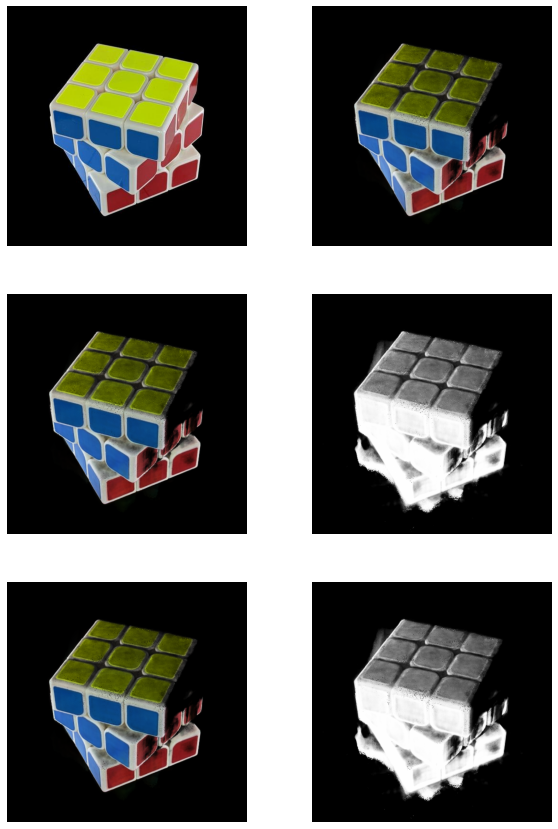

In [24]:
USE_PHONG_FULL = True
USE_MU_SMOOTHING = True
SAMPLING_MULTIPLIER = 0.5
rendered1, lm1 = get_rgb_test(render_data, models, light_data, chunk_size = 1024*8, **render_kwargs)

USE_MU_SMOOTHING = False
SAMPLING_MULTIPLIER = 0.5
rendered2, lm2 = get_rgb_test(render_data, models, light_data, chunk_size = 1024*8, **render_kwargs)

plot_images([images[ri], rendered1, rendered1, lm1, rendered2, lm2], 3, 2)

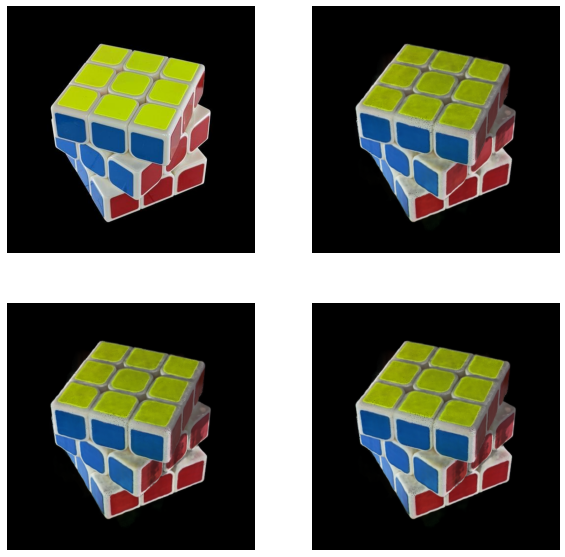

In [21]:
USE_PHONG_FULL = False
rendered1 = get_rgb_test(render_data, models, light_data, chunk_size = 1024*8, **render_kwargs)

USE_PHONG_FULL = True
SAMPLING_MULTIPLIER = .5
rendered2 = get_rgb_test(render_data, models, light_data, chunk_size = 1024*8, **render_kwargs)

USE_MU_SMOOTHING = False
SAMPLING_MULTIPLIER = .5
rendered3 = get_rgb_test(render_data, models, light_data, chunk_size = 1024*8, **render_kwargs)

plot_images([images[ri], rendered1, rendered2, rendered3], 2, 2)

In [22]:
USE_PHONG_FULL = False

light_data ={
    'ambient': 0.1,
    'lights': [
        {
        'loc': np.array([2., 2., 2.]),
        'intensity': 20.,
        'color': np.array([1., .5, .5])
        },
        {
        'loc': np.array([-2., 0., 2.]),
        'intensity': 20.,
        'color': np.array([.5, 1., .5])
        }
    ]
}

ri = 82
print(ri)

render_data = [H, W, focal, poses[ri], near, far]
frames = []
for i in range(120):
    rad = 2.0
    z = 0.5
    x = math.sin(math.radians(i * 3)) * rad
    y = math.cos(math.radians(i * 3)) * rad
    loc1 = np.array([x, y, z], dtype = np.float32)
    loc2 = np.array([-x, -y, z], dtype = np.float32)

    light_data['lights'][0]['loc'] = loc1
    light_data['lights'][1]['loc'] = loc2


    frame = get_rgb_test(render_data, models, light_data, chunk_size = 1024*8, **render_kwargs)
    print('Generated frame: ', i + 1)
    frames.append(frame)

frame = np.stack(frames, 0)
imageio.mimwrite('lighting_test_004.mp4', to8b(frames), fps=30, quality=8)

82
Generated frame:  1
Generated frame:  2
Generated frame:  3
Generated frame:  4
Generated frame:  5
Generated frame:  6
Generated frame:  7
Generated frame:  8
Generated frame:  9
Generated frame:  10
Generated frame:  11
Generated frame:  12
Generated frame:  13
Generated frame:  14
Generated frame:  15
Generated frame:  16
Generated frame:  17
Generated frame:  18
Generated frame:  19
Generated frame:  20
Generated frame:  21
Generated frame:  22
Generated frame:  23
Generated frame:  24
Generated frame:  25
Generated frame:  26
Generated frame:  27
Generated frame:  28
Generated frame:  29
Generated frame:  30
Generated frame:  31
Generated frame:  32
Generated frame:  33
Generated frame:  34
Generated frame:  35
Generated frame:  36
Generated frame:  37
Generated frame:  38
Generated frame:  39
Generated frame:  40
Generated frame:  41
Generated frame:  42
Generated frame:  43
Generated frame:  44
Generated frame:  45
Generated frame:  46
Generated frame:  47
Generated frame:  4

In [21]:
USE_PHONG_FULL = True
USE_MU_SMOOTHING = True
SAMPLING_MULTIPLIER = 0.5

USE_PHONG_FULL = False

light_data ={
    'ambient': 0.1,
    'lights': [
        {
        'loc': np.array([2., 2., 2.]),
        'intensity': 20.,
        'color': np.array([1., .5, .5])
        },
        # {
        # 'loc': np.array([-2., 0., 2.]),
        # 'intensity': 20.,
        # 'color': np.array([.5, 1., .5])
        # }
    ]
}

ri = 82
print(ri)

render_data = [H, W, focal, poses[ri], near, far]
frames = []
for i in range(120):
    rad = 2.0
    z = 0.5
    x = math.sin(math.radians(i * 3)) * rad
    y = math.cos(math.radians(i * 3)) * rad
    loc1 = np.array([x, y, z], dtype = np.float32)
    # loc2 = np.array([-x, -y, z], dtype = np.float32)

    light_data['lights'][0]['loc'] = loc1
    # light_data['lights'][1]['loc'] = loc2

    _, frame = get_rgb_test(render_data, models, light_data, chunk_size = 1024*8, **render_kwargs)

    print('Generated frame: ', i + 1)
    frames.append(frame)

frame = np.stack(frames, 0)
imageio.mimwrite('lighting_test_006.mp4', to8b(frames), fps=30, quality=8)

82
Generated frame:  1
Generated frame:  2
Generated frame:  3
Generated frame:  4
Generated frame:  5
Generated frame:  6
Generated frame:  7
Generated frame:  8
Generated frame:  9
Generated frame:  10
Generated frame:  11
Generated frame:  12
Generated frame:  13
Generated frame:  14
Generated frame:  15
Generated frame:  16
Generated frame:  17
Generated frame:  18
Generated frame:  19
Generated frame:  20
Generated frame:  21
Generated frame:  22
Generated frame:  23
Generated frame:  24
Generated frame:  25
Generated frame:  26
Generated frame:  27
Generated frame:  28
Generated frame:  29
Generated frame:  30
Generated frame:  31
Generated frame:  32
Generated frame:  33
Generated frame:  34
Generated frame:  35
Generated frame:  36
Generated frame:  37
Generated frame:  38
Generated frame:  39
Generated frame:  40
Generated frame:  41
Generated frame:  42
Generated frame:  43
Generated frame:  44
Generated frame:  45
Generated frame:  46
Generated frame:  47
Generated frame:  4